# BG-NBD ve Gamma-Gamma ile CLTV Prediction

---

## İş Problemi (Business Problem)

FLO satış ve pazarlama faaliyetleri için roadmap belirlemek istemektedir.  
Şirketin orta uzun vadeli plan yapabilmesi için var olan müşterilerin gelecekte şirkete sağlayacakları potansiyel değerin tahmin edilmesi gerekmektedir.

---

## Veri Seti Hikayesi

Veri seti son alışverişlerini 2020 - 2021 yıllarında **OmniChannel** (hem online hem offline alışveriş yapan) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

### Değişkenler:
- **master_id**: Eşsiz müşteri numarası  
- **order_channel** : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, iOS, Desktop, Mobile, Offline)  
- **last_order_channel** : En son alışverişin yapıldığı kanal  
- **first_order_date** : Müşterinin yaptığı ilk alışveriş tarihi  
- **last_order_date** : Müşterinin yaptığı son alışveriş tarihi  
- **last_order_date_online** : Müşterinin online platformda yaptığı son alışveriş tarihi  
- **last_order_date_offline** : Müşterinin offline platformda yaptığı son alışveriş tarihi  
- **order_num_total_ever_online** : Müşterinin online platformda yaptığı toplam alışveriş sayısı  
- **order_num_total_ever_offline** : Müşterinin offline'da yaptığı toplam alışveriş sayısı  
- **customer_value_total_ever_offline** : Müşterinin offline alışverişlerinde ödediği toplam ücret  
- **customer_value_total_ever_online** : Müşterinin online alışverişlerinde ödediği toplam ücret  
- **interested_in_categories_12** : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi  


## Veri Ön Hazırlık (Data Preprocessing)


In [2]:
import pandas as pd
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

# 1. Veri setini yükle
df_ = pd.read_csv("data.csv")
df = df_.copy()
print(f"Veri seti boyutu: {df.shape[0]} satır, {df.shape[1]} sütun\n")
display(df.head())

# 2. Aykırı değer fonksiyonları
def outlier_thresholds(dataframe, variable):
    """Verilen değişken için alt ve üst sınırları hesaplar."""
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    """Aykırı değerleri sınırlarla değiştirir."""
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

# 3. Aykırı değerleri baskıla
print("\nAykırı değer baskılama işlemi yapılıyor...")
columns = [
    "order_num_total_ever_online",
    "order_num_total_ever_offline",
    "customer_value_total_ever_offline",
    "customer_value_total_ever_online"
]

for col in columns:
    replace_with_thresholds(df, col)

print("Aykırı değerler baskılandı.\n")

# 4. Yeni değişkenler
print("Toplam sipariş ve toplam harcama değişkenleri ekleniyor...")
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
display(df.head())

# 5. Tarih dönüşümü
print("\nTarih değişkenleri datetime tipine dönüştürülüyor...")
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)
df.info()

# 6. Fonksiyonlaştırma
def data_prep(dataframe):
    """Temel ön hazırlık işlemleri: outlier baskılama, yeni değişkenler, tarih dönüşümü."""
    
    # Aykırı değer baskılama
    cols = [
        "order_num_total_ever_online",
        "order_num_total_ever_offline",
        "customer_value_total_ever_offline",
        "customer_value_total_ever_online"
    ]
    for col in cols:
        replace_with_thresholds(dataframe, col)

    # Yeni değişkenler
    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]

    # Tarih dönüşümleri
    date_cols = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_cols] = dataframe[date_cols].apply(pd.to_datetime)

    return dataframe

print("\nFonksiyon ile veri ön hazırlığı uygulanıyor...")
df_prep = data_prep(df.copy())
display(df_prep.head())


Veri seti boyutu: 19945 satır, 12 sütun



,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]



Aykırı değer baskılama işlemi yapılıyor...
Aykırı değerler baskılandı.

Toplam sipariş ve toplam harcama değişkenleri ekleniyor...


,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98



Tarih değişkenleri datetime tipine dönüştürülüyor...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98


## CLTV Veri Yapısının Oluşturulması


In [4]:
    last_order_date = df["last_order_date"].max()
    print(f"Veri setindeki son alışveriş tarihi: {last_order_date}")
    analysis_date = dt.datetime(2021, 6, 1)
    print(f"Analiz tarihi: {analysis_date}\n")
    
    # T: müşterinin yaşı
    # Frequency: toplam alışveriş sayısı
    # Monetary: ortalama alışveriş başına harcama
    
    print("CLTV veri yapısı oluşturuluyor...\n")
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = df["master_id"]
    cltv_df["recency_cltv_weekly"] = (
        (df["last_order_date"] - df["first_order_date"]).dt.days / 7
    )
    
    cltv_df["T_weekly"] = (
        (analysis_date - df["first_order_date"]).dt.days / 7
    )
    
    cltv_df["frequency"] = df["order_num_total"]
    cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]
    
    print("CLTV veri seti boyutu:", cltv_df.shape)
    display(cltv_df.head())


Veri setindeki son alışveriş tarihi: 2021-05-30 00:00:00
Analiz tarihi: 2021-06-01 00:00:00

CLTV veri yapısı oluşturuluyor...

CLTV veri seti boyutu: (19945, 5)


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


## BG/NBD ve Gamma-Gamma Modelleri ile Müşteri Yaşam Boyu Değeri (CLTV) Hesaplama


In [6]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
import numpy as np

# 1. Model için filtreleme: frequency > 0 ve monetary > 0
cltv_df_model = cltv_df.copy()
cltv_df_model = cltv_df_model[(cltv_df_model['frequency'] > 0)].copy()

# Monetary sıfır veya negatif olanları NaN yapıp temizle
cltv_df_model['monetary_cltv_avg'] = cltv_df_model['monetary_cltv_avg'].replace(0, np.nan)
cltv_df_model = cltv_df_model.dropna(subset=['monetary_cltv_avg'])

print("Filtreleme sonrası veri boyutu:", cltv_df_model.shape)

# 2. BG/NBD Modeli
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    cltv_df_model['frequency'],
    cltv_df_model['recency_cltv_weekly'],
    cltv_df_model['T_weekly']
)
print("BG/NBD modeli fit edildi.\n")

# 3 ay ve 6 ay için beklenen satın almalar
cltv_df_model["exp_sales_3_month"] = bgf.predict(
    4*3,
    cltv_df_model['frequency'],
    cltv_df_model['recency_cltv_weekly'],
    cltv_df_model['T_weekly']
)
cltv_df_model["exp_sales_6_month"] = bgf.predict(
    4*6,
    cltv_df_model['frequency'],
    cltv_df_model['recency_cltv_weekly'],
    cltv_df_model['T_weekly']
)

print("3. ayda en çok satın alma beklenen 10 müşteri:")
display(cltv_df_model.sort_values("exp_sales_3_month", ascending=False).head(10))

print("6. ayda en çok satın alma beklenen 10 müşteri:")
display(cltv_df_model.sort_values("exp_sales_6_month", ascending=False).head(10))

# 3. Gamma-Gamma Modeli
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(
    cltv_df_model['frequency'],
    cltv_df_model['monetary_cltv_avg']
)

# Ortalama müşteri değeri
cltv_df_model["exp_average_value"] = ggf.conditional_expected_average_profit(
    cltv_df_model['frequency'],
    cltv_df_model['monetary_cltv_avg']
)
print("Gamma-Gamma modeli ile ortalama müşteri değeri tahminlendi.\n")
display(cltv_df_model.head())

# 4. 6 Aylık CLTV Hesaplama
cltv = ggf.customer_lifetime_value(
    bgf,
    cltv_df_model['frequency'],
    cltv_df_model['recency_cltv_weekly'],
    cltv_df_model['T_weekly'],
    cltv_df_model['monetary_cltv_avg'],
    time=6,           # 6 aylık CLTV
    freq="W",         # haftalık veri
    discount_rate=0.01
)

cltv_df_model["cltv"] = cltv

print("CLTV hesaplandı.\n")
print("CLTV değeri en yüksek 20 müşteri:")
display(cltv_df_model.sort_values("cltv", ascending=False).head(20))


Filtreleme sonrası veri boyutu: (19945, 5)
BG/NBD modeli fit edildi.

3. ayda en çok satın alma beklenen 10 müşteri:


C:\Users\user\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


6. ayda en çok satın alma beklenen 10 müşteri:


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


Gamma-Gamma modeli ile ortalama müşteri değeri tahminlendi.



,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33


CLTV hesaplandı.

CLTV değeri en yüksek 20 müşteri:


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1.09,2.19,1449.06,3327.78
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,1.97,3.94,767.36,3172.39
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,0.72,1.44,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,1.57,3.13,506.17,1662.61
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31,166.71,1628.89
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,1.27,2.53,611.49,1623.81
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,0.79,1.59,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,0.87,1.74,778.05,1423.00


## CLTV'ye Göre Müşteri Segmentlerinin Oluşturulması ve Aksiyon Önerileri


In [14]:
# Segmentler: A (en değerli), B, C, D (en az değerli)
cltv_df_model["cltv_segment"] = pd.qcut(
    cltv_df_model["cltv"], 
    4, 
    labels=["D", "C", "B", "A"]
)

print("CLTV segmentleri oluşturuldu. İlk 10 müşteri:")
display(cltv_df_model[["customer_id", "cltv", "cltv_segment"]].head(10))

print("\nSegment dağılımı:")
display(cltv_df_model["cltv_segment"].value_counts())

print("\nÖrnek aksiyon önerileri:")
# A Segmenti (en değerli müşteriler)
print("\nA Segmenti (en değerli müşteriler):")
print("- Sadakat programı teklifleri ile bağlılığı artırın.")
print("- Özel kampanya ve erken erişim fırsatları sunun.")
# D Segmenti (en düşük CLTV müşteriler)
print("\nD Segmenti (en az değerli müşteriler):")
print("- Yeniden kazanım kampanyaları ile tekrar alışverişi teşvik edin.")
print("- E-posta ve indirim kampanyaları ile ilgilerini artırın.")

CLTV segmentleri oluşturuldu. İlk 10 müşteri:


,customer_id,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,395.73,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,199.43,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,170.22,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,98.95,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,95.01,D
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,57.43,D
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,134.28,C
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,97.70,D
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,322.73,A
9,1143f032-440d-11ea-8b43-000d3a38a36f,75.22,D



Segment dağılımı:


cltv_segment
D    4987
C    4986
B    4986
A    4986
Name: count, dtype: int64


Örnek aksiyon önerileri:

A Segmenti (en değerli müşteriler):
- Sadakat programı teklifleri ile bağlılığı artırın.
- Özel kampanya ve erken erişim fırsatları sunun.

D Segmenti (en az değerli müşteriler):
- Yeniden kazanım kampanyaları ile tekrar alışverişi teşvik edin.
- E-posta ve indirim kampanyaları ile ilgilerini artırın.


## Segment Bazlı CLTV ve Beklenen Satın Alma Analizi

In [19]:
print("Segment bazlı özet tablo oluşturuluyor...\n")
segment_summary = cltv_df_model.groupby("cltv_segment").agg({
    "cltv": "mean",
    "exp_sales_6_month": "mean",
    "exp_average_value": "mean",
    "customer_id": "count"
}).rename(columns={"customer_id": "count"}).sort_values("cltv", ascending=False)

display(segment_summary)

print("\nYönetim için yorumlar ve aksiyon önerileri:")

print("\n- A Segmenti: En yüksek CLTV ve beklenen satın alma. Sadakat ve premium kampanyalar ile değer daha da artırılabilir.")
print("- B Segmenti: Orta-yüksek değerli müşteriler. Cross-sell ve upsell fırsatları değerlendirilebilir.")
print("- C Segmenti: Orta-düşük değerli müşteriler. Yeniden kazanım kampanyaları uygulanabilir.")
print("- D Segmenti: En düşük değerli müşteriler. Maliyet etkin küçük promosyonlarla tekrar alışverişi teşvik edilebilir.")


Segment bazlı özet tablo oluşturuluyor...



,cltv,exp_sales_6_month,exp_average_value,count
cltv_segment,,,,
A,362.32,1.55,238.02,4986
B,199.53,1.20,168.00,4986
C,138.31,1.05,132.25,4986
D,80.34,0.82,98.69,4987



Yönetim için yorumlar ve aksiyon önerileri:

- A Segmenti: En yüksek CLTV ve beklenen satın alma. Sadakat ve premium kampanyalar ile değer daha da artırılabilir.
- B Segmenti: Orta-yüksek değerli müşteriler. Cross-sell ve upsell fırsatları değerlendirilebilir.
- C Segmenti: Orta-düşük değerli müşteriler. Yeniden kazanım kampanyaları uygulanabilir.
- D Segmenti: En düşük değerli müşteriler. Maliyet etkin küçük promosyonlarla tekrar alışverişi teşvik edilebilir.


## CLTV ve Segment Bazlı Görselleştirme

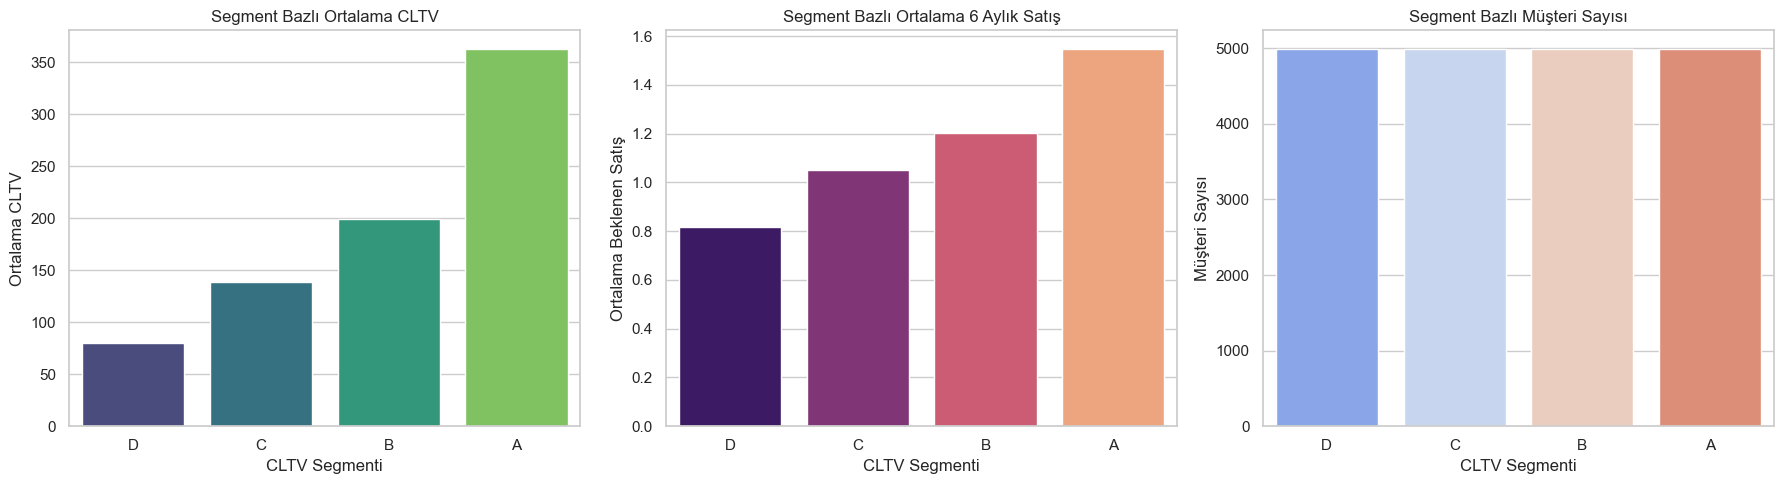

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 3 grafiği yan yana göstermek için subplot
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# 1. Segmentlerin ortalama CLTV
sns.barplot(x=segment_summary.index, y=segment_summary["cltv"], palette="viridis", ax=axes[0])
axes[0].set_title("Segment Bazlı Ortalama CLTV")
axes[0].set_xlabel("CLTV Segmenti")
axes[0].set_ylabel("Ortalama CLTV")

# 2. Segmentlerin ortalama beklenen 6 aylık satış
sns.barplot(x=segment_summary.index, y=segment_summary["exp_sales_6_month"], palette="magma", ax=axes[1])
axes[1].set_title("Segment Bazlı Ortalama 6 Aylık Satış")
axes[1].set_xlabel("CLTV Segmenti")
axes[1].set_ylabel("Ortalama Beklenen Satış")

# 3. Segmentlerin müşteri sayısı
sns.barplot(x=segment_summary.index, y=segment_summary["count"], palette="coolwarm", ax=axes[2])
axes[2].set_title("Segment Bazlı Müşteri Sayısı")
axes[2].set_xlabel("CLTV Segmenti")
axes[2].set_ylabel("Müşteri Sayısı")

plt.tight_layout()
plt.show()